In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import datasets
import ipywidgets as widgets
from ipywidgets import interact
import ruptures as rpt

In [2]:
df = pd.read_csv('us_covid19_daily.csv')
df.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20201206,56,14534035,161986294,13592.0,101487.0,585676.0,20145.0,31946.0,7094.0,...,204063869,2020-12-06T24:00:00Z,0,0,1138,2256,1172590,176771,1634532,9cf16504f91958e803a2197daf8c2528a4eddc18
1,20201205,56,14357264,160813704,13433.0,101190.0,583420.0,19950.0,31831.0,7005.0,...,202429337,2020-12-05T24:00:00Z,0,0,2445,3316,1526995,211073,2169756,6249216c5f097c94ce33a811dab011a483a42404
2,20201204,56,14146191,159286709,12714.0,101276.0,580104.0,19858.0,31608.0,6999.0,...,200259581,2020-12-04T24:00:00Z,0,0,2563,4652,1260657,224831,1854869,ae30ea088584335ba4d57ee927f8dbda6add74db
3,20201203,56,13921360,158026052,15106.0,100755.0,575452.0,19723.0,31276.0,6867.0,...,198404712,2020-12-03T24:00:00Z,0,0,2706,5331,1238465,210204,1828230,0f253d185ecb336cdd18a4c61996eda1b7eef13b
4,20201202,56,13711156,156787587,14368.0,100322.0,570121.0,19680.0,31038.0,6855.0,...,196576482,2020-12-02T24:00:00Z,0,0,2733,5028,982032,195796,1459202,477c17b6302d0485195e77ecf8270a974f7a3c82


In [3]:
df.columns

Index(['date', 'states', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'dateChecked', 'death', 'hospitalized', 'totalTestResults',
       'lastModified', 'total', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease', 'hash'],
      dtype='object')

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.sort_values('date', inplace=True)  # Sort by date
df.reset_index(drop=True, inplace=True)

In [5]:
df['daily_cases'] = df['positive'].diff()
df.dropna(subset=['daily_cases'], inplace=True)

In [6]:

def print_breakpoints(model_param=10, data_transform="Normal", algo_type='Pelt'):
    time_series = None
    if data_transform == "Rolling":
        time_series = df['daily_cases'].rolling(window=7).mean()
        time_series = time_series.dropna()
        time_series = time_series.values
    elif data_transform == "LogTransform":
        time_series = np.log(df['daily_cases'] + 1).values
    else:
        time_series = df['daily_cases'].values

    # Fit the Pelt model
    if algo_type == "Dynp":
        algo = rpt.Dynp(model="l2").fit(time_series)
        breakpoints = algo.predict(n_bkps=model_param)
    else:
        algo = rpt.Pelt(model='rbf').fit(time_series)
        breakpoints = algo.predict(pen=model_param)
    
    
    # print(f"Breakpoints at model_param={model_param:2d}:", breakpoints)
    # for bkp in breakpoints[:-1][:10]:  # the last breakpoint is usually end of the series
    #     date_of_change = df.iloc[bkp].date
    #     print(f"Detected change at index {bkp}, date = {date_of_change}")


    rpt.display(time_series, breakpoints, figsize=(10, 6))
    plt.title("Changepoint Detection on Daily New COVID-19 Cases (U.S.)")
    plt.xlabel("Time Index")
    plt.ylabel("Daily Cases")
    plt.show()

data_transform = widgets.Dropdown(
    options=['Normal', 'Rolling', 'LogTransform'],
    value='Normal',
    description='Data Transform'
)

algo_type = widgets.Dropdown(
    options=['Pelt', 'Dynp'],
    value='Pelt',
    description='Algorithm used'
)


interact(print_breakpoints, 
         model_param=widgets.IntSlider(value=10, min=1, max=50, step=1, description='Model Parameter'),
         data_transform=data_transform,
         algo_type=algo_type,
         )

interactive(children=(IntSlider(value=10, description='Model Parameter', max=50, min=1), Dropdown(description=…

<function __main__.print_breakpoints(model_param=10, data_transform='Normal', algo_type='Pelt')>

Breakpoints: [50, 145, 270, 300]
Detected change at index 50, date = 2020-03-13 00:00:00
Detected change at index 145, date = 2020-06-16 00:00:00
Detected change at index 270, date = 2020-10-19 00:00:00


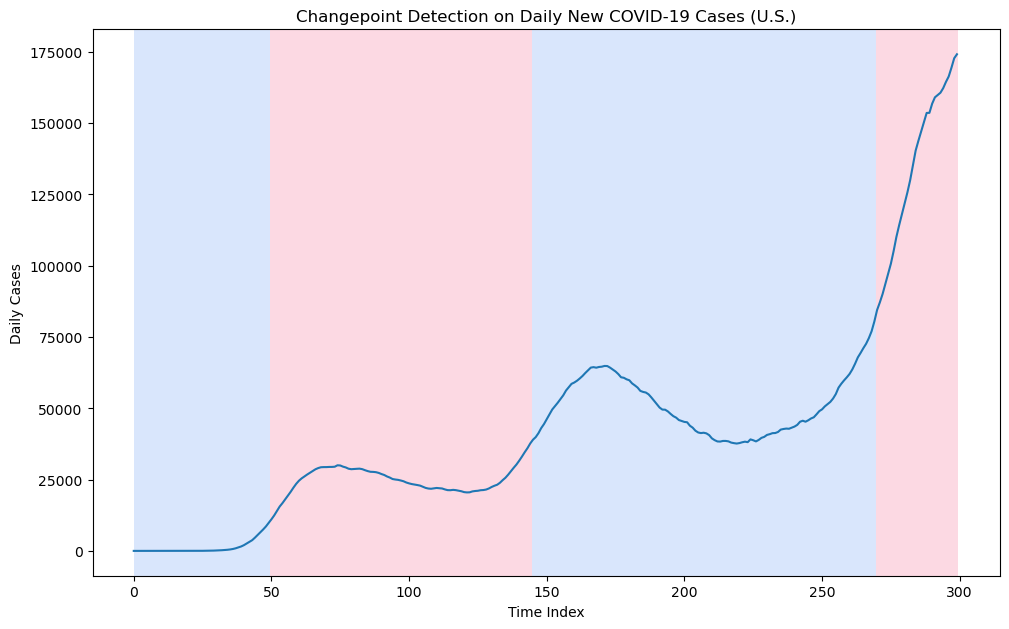

In [69]:
time_series = df['daily_cases'].rolling(window=20, center=True).mean()
time_series = time_series.dropna()
time_series = time_series.values
# time_series = df['daily_cases'].values

algo = rpt.Pelt(model='rbf').fit(time_series)
breakpoints = algo.predict(pen=20)

print(f"Breakpoints:", breakpoints)
for bkp in breakpoints[:-1][:10]:  # the last breakpoint is usually end of the series
    date_of_change = df.iloc[bkp].date
    print(f"Detected change at index {bkp}, date = {date_of_change}")


rpt.display(time_series, breakpoints, figsize=(10, 6))
plt.title("Changepoint Detection on Daily New COVID-19 Cases (U.S.)")
plt.xlabel("Time Index")
plt.ylabel("Daily Cases")
plt.show()

In [52]:
algo = rpt.Pelt(model='rbf').fit(df['daily_cases'].rolling(window=20, center=True).mean().values - df['daily_cases'].rolling(window=20).mean().values)
breakpoints = algo.predict(pen=100)
print(f"Breakpoints:", breakpoints)


Breakpoints: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 319]


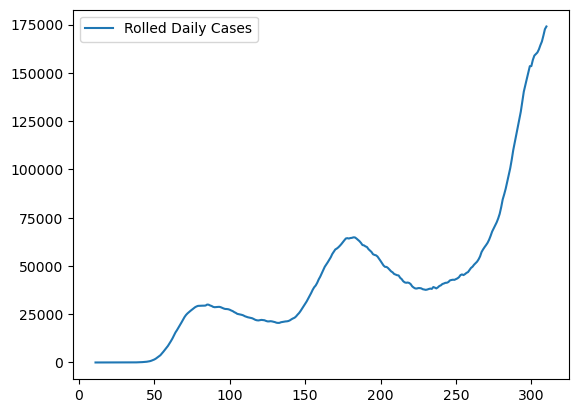

In [68]:
rolled_series = df['daily_cases'].rolling(window=20, center=True).mean()
rolled_series = rolled_series.dropna()  # remove the edges that are NaN
plt.plot(rolled_series, label='Rolled Daily Cases')
plt.legend()
plt.show()